<a href="https://colab.research.google.com/github/kashtienooh/CarND-Advanced-Lane-Lines-master/blob/master/Copy_of_Exercise2_RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2 - RUL Prediction for Turbofine Engines with 1D Convolutional Neural Networks 🩺

#🚨🚨🚨🚨🚨🚨 Please make a local copy in Drive 🚨🚨🚨🚨🚨🚨
File -> Save a copy in Drive

DO NOT run codes directly on this notebook




Prognostics is the prediction of Remaining useful life of instance of failure of a component based on the knowledge about current and future coditions of operation (obtained through various sensors or physical models).

The new C-MAPSS dataset DS02 from NASA provides degradation trajectories of 9 turbofan engines with unknown and different initial health condition for complete flights and two failure modes (HPT efficiency degradation & HPT efficiency degradation combined with LPT efficiency and capacity degradation). The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. A total number of 6.5M time stamps are available. Dataset copyright (c) by Manuel Arias.

**For training simplicity, the dataset has been preprocessed. The dataset has been downsampled from 1Hz to 0.1 Hz with an IIR 8th Order Chebyshev filter. Data format has been converted from double to float precison.**

Notebook Author: Mengjie Zhao, Modified by Chi-Ching Hsu

## Imports 💼

In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Download dataset 🔗

In [ ]:
!gdown --id 1t4qcB8QfRoZtqTnDqvVnH0uL2puXlW6R

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1t4qcB8QfRoZtqTnDqvVnH0uL2puXlW6R
From (redirected): https://drive.google.com/uc?id=1t4qcB8QfRoZtqTnDqvVnH0uL2puXlW6R&confirm=t&uuid=5a9d93cf-d690-445d-8968-e043901968b1
To: /content/ncmapss_ds02.csv
100% 122M/122M [00:02<00:00, 50.0MB/s]


# Data exploration 🔍
![](https://drive.google.com/uc?id=1r52cFUpKou-tlWsqaSYX8MXeYfQqirhE)



### Feature descriptions

| Symbol |           Description           | Units |
|:------:|:-------------------------------:|:-----:|
|   Wf   |            Fuel flow            |  pps  |
|   Nf   |        Physical fan speed       |  rpm  |
|   Nc   |       Physical core speed       |  rpm  |
|   T24  | Total temperature at LPC outlet |   °R  |
|   T30  | Total temperature at HPC outlet |   °R  |
|   T48  | Total temperature at HPT outlet |   °R  |
|   T50  | Total temperature at LPT outlet |   °R  |
|   P15  |  Total pressure in bypass-duct  |  psia |
|   P2   |   Total pressure at fan inlet   |  psia |
|   P21  |   Total pressure at fan outlet  |  psia |
|   P24  |   Total pressure at LPC outlet  |  psia |
|  Ps30  |  Static pressure at HPC outlet  |  psia |
|   P40  | Total pressure at burner outlet |  psia |
|   P50  |   Total pressure at LPT outlet  |  psia |
|   alt  |             Altitude            |   ft  |
|  Mach  |        Flight Mach number       |   -   |
|   TRA  |     Throttle–resolver angle     |   %   |
|   T2   |  Total temperature at fan inlet |   °R  |
|  cycle |       Flight cycle number       |   -   |
|   Fc   |           Flight class          |   -   |
|   hs   |           Health state          |   -   |

In [ ]:
df = pd.read_csv("./ncmapss_ds02.csv")
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [ ]:
df.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
count,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,...,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000
mean,553.773261,1305.850995,1624.971227,1095.696343,10.873508,8.294637,11.039095,13.643750,208.496462,212.067515,...,2.253705,21119.237345,0.610494,67.194135,470.945280,36.166254,2.885379,11.667088,0.242413,36.923423
std,17.911969,55.450514,98.490373,51.542820,2.151641,1.772237,2.184407,2.623686,44.015363,44.661923,...,0.570109,6289.970530,0.079231,14.527711,16.562547,21.888520,0.386773,6.039347,0.428543,21.871899
min,478.632600,1059.667800,1209.931600,880.090700,5.852047,4.347817,5.941164,6.836902,79.552380,81.277596,...,0.669135,9882.690000,0.307302,19.149189,417.287570,0.000000,1.000000,2.000000,0.000000,1.000000
25%,541.163970,1275.104050,1576.463600,1062.239200,9.047318,6.723060,9.185095,11.490683,177.011890,180.088135,...,1.862427,15698.589500,0.552379,57.695049,457.398350,18.000000,3.000000,5.000000,0.000000,18.000000
50%,551.275940,1304.876100,1634.922400,1087.750400,10.440776,7.942872,10.599772,13.147205,198.354350,201.783000,...,2.120128,21750.955000,0.623288,73.139915,469.305800,35.000000,3.000000,11.000000,0.000000,36.000000
75%,565.815665,1340.213050,1683.188100,1128.510400,12.557189,9.760832,12.748416,15.541450,235.666880,239.740805,...,2.575994,26692.051500,0.673824,78.666230,485.250000,54.000000,3.000000,18.000000,0.000000,54.000000
max,610.117900,1484.438500,1920.566000,1282.403800,16.686320,12.159272,16.940426,21.708801,376.933350,382.565220,...,4.619399,34629.797000,0.738229,91.356170,505.425720,88.000000,3.000000,20.000000,1.000000,89.000000


### Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        

<Axes: xlabel='Unit # [-]', ylabel='Flight Class # [-]'>

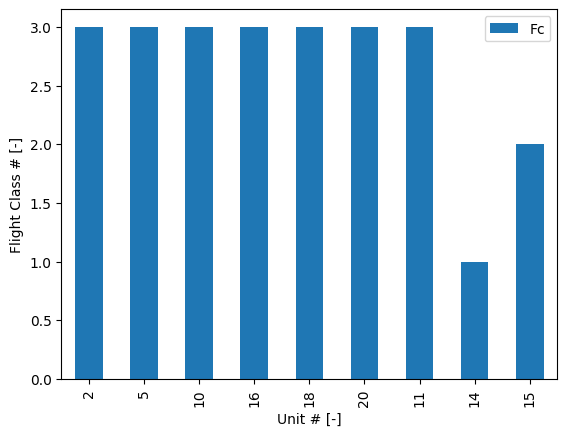

In [ ]:
df.drop_duplicates(
    subset=['unit','Fc'], keep='last'
    ).plot(
        x='unit', y='Fc',
        kind='bar',
        xlabel='Unit # [-]',
        ylabel='Flight Class # [-]'
    )

## Feature Overview

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [ ]:
LABELS = ['RUL']
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [ ]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Axes: >

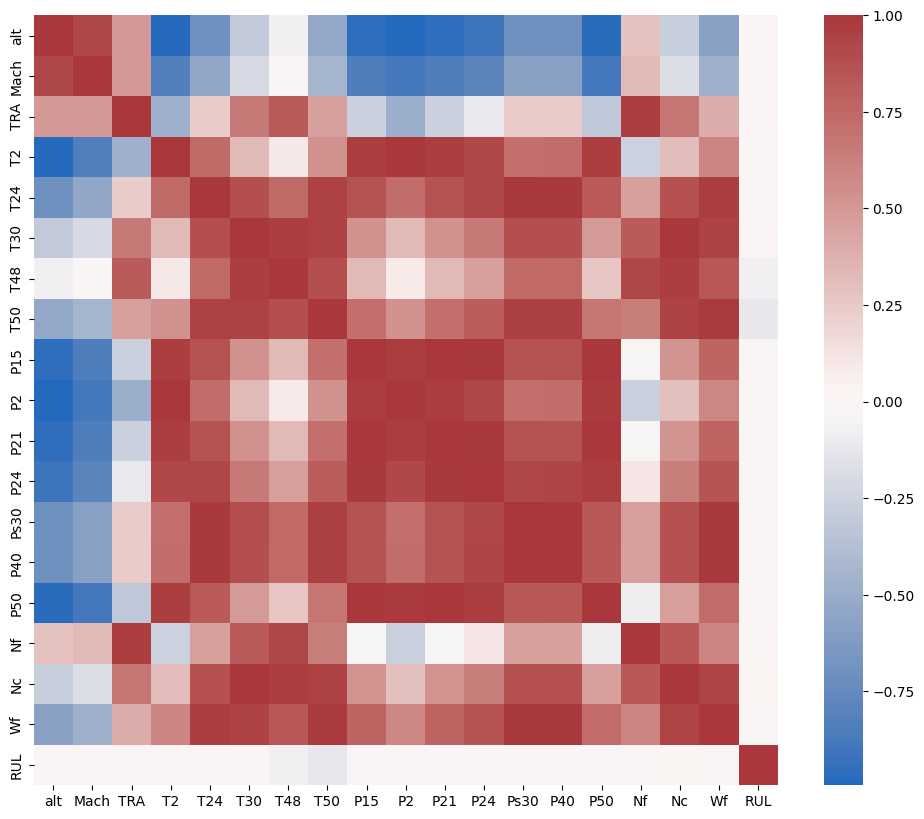

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(df[W_VAR+XS_VAR+LABELS].corr(), cmap="vlag")

### Flight Traces
visualize a single flight trace of a given unit

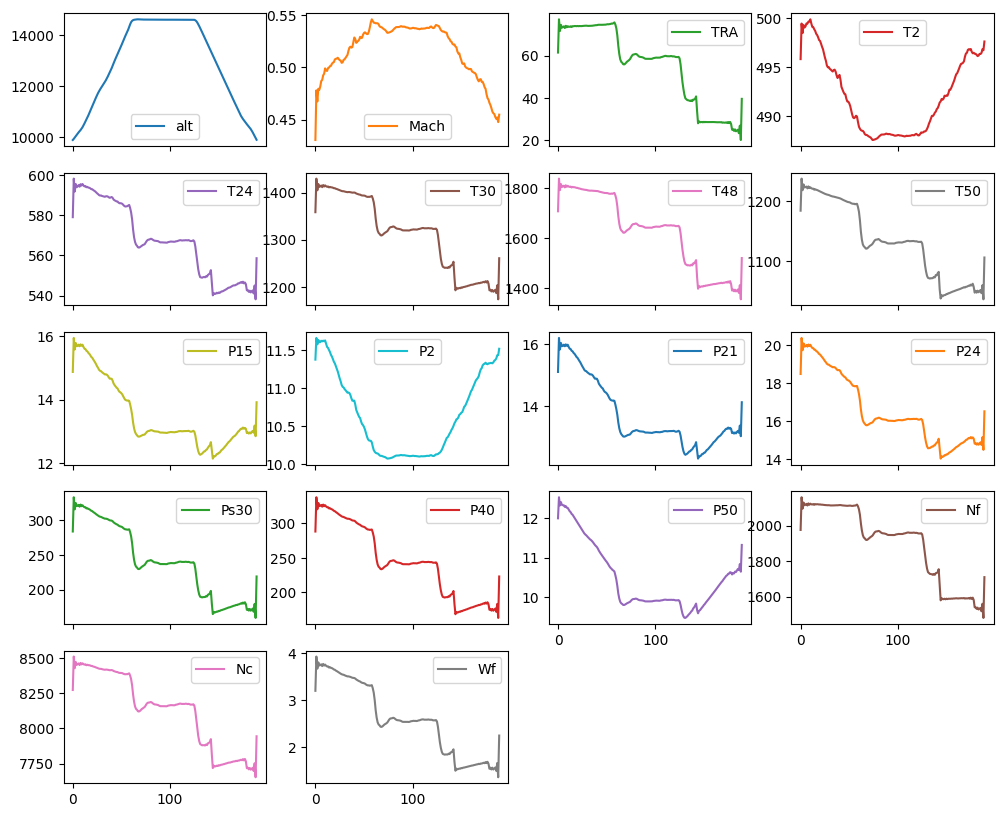

In [ ]:
unit = 14
cycle = 70
df_u_sel = df.loc[(df.unit == unit) & (df.cycle == cycle)][W_VAR+XS_VAR]
df_u_sel.reset_index(inplace=True, drop=True)
axes = df_u_sel.plot(figsize=(12, 10), subplots=True, layout=(5, 4))

### Flight envelope

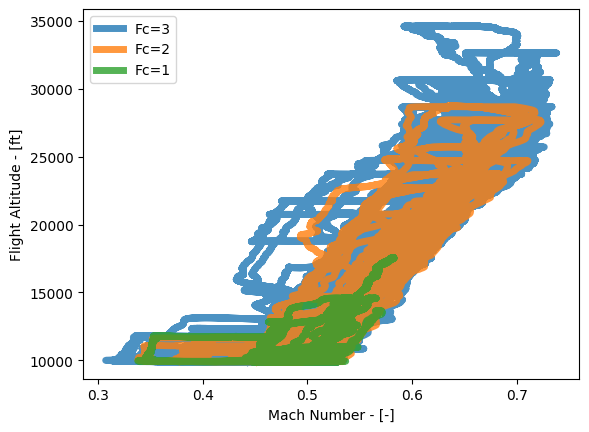

In [ ]:
f, ax = plt.subplots(1, 1)
for i in [3, 2, 1]:
    df.loc[df['Fc'] == i].plot(x='Mach', y='alt', alpha=0.8, label=f'Fc={i}', ax=ax, lw=5)
plt.xlabel('Mach Number - [-]')
plt.ylabel('Flight Altitude - [ft]')
plt.legend()

## Histogram of Flight Conditions

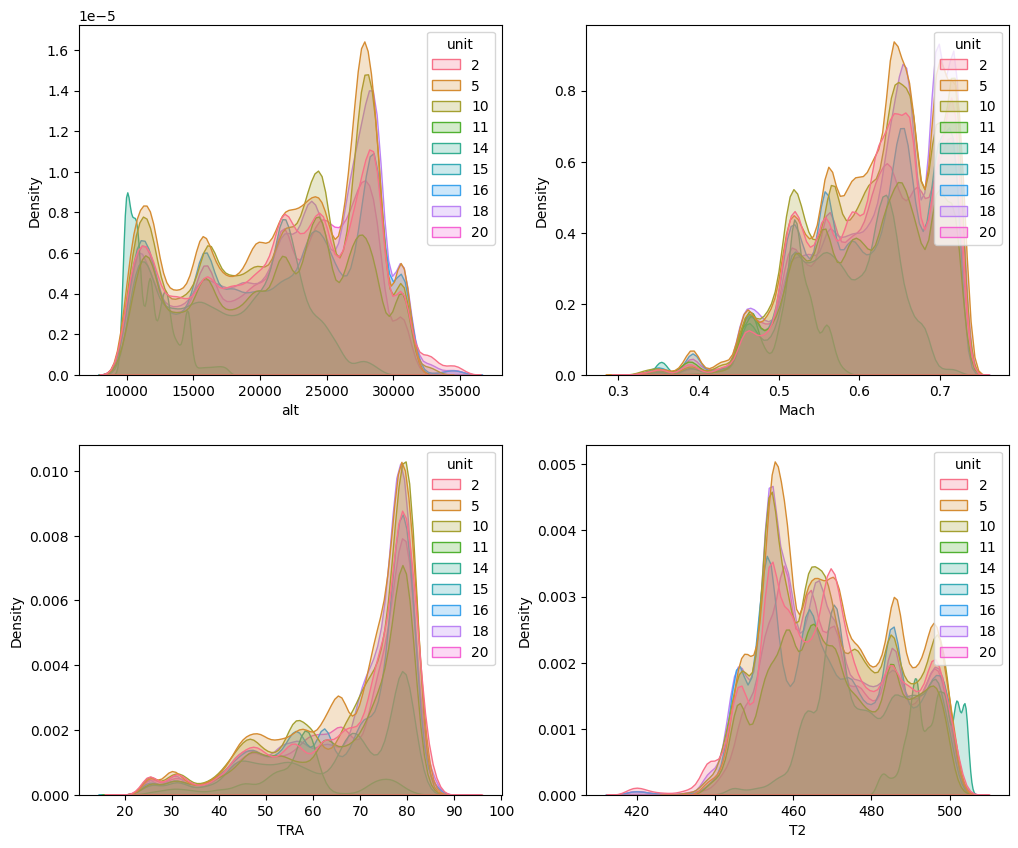

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, var in enumerate(W_VAR):
    sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', fill=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))

# Developing the prognostics model 💻


## Define Sequence Dataset


In [ ]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, window=50, stride=1, horizon=1, device='cpu'):
        """Sliding window dataset with RUL label

        Args:
            dataframe (pd.DataFrame): dataframe containing scenario descriptors and sensor reading
            window (int, optional): sequence window length. Defaults to 50.
            stride (int, optional): data stride length. Defaults to 1.
            horizon (int, optional): prediction forcasting length. Defaults to 1.
        """
        self.window = window
        self.stride = stride
        self.horizon = horizon

        self.X = np.array(dataframe[XS_VAR+W_VAR].values).astype(np.float32)
        self.y = np.array(dataframe['RUL'].values).astype(np.float32)
        if 'ds' in dataframe.columns:
            unqiue_cycles = dataframe[['ds', 'unit', 'cycle']].value_counts(sort=False)
        else:
            unqiue_cycles = dataframe[['unit', 'cycle']].value_counts(sort=False)
        self.indices = torch.from_numpy(self._get_indices(unqiue_cycles)).to(device)


    def _get_indices(self, unqiue_cycles):
        cycles = unqiue_cycles.to_numpy()
        idx_list = []
        for i, c_count in enumerate(cycles):
            c_start = sum(cycles[:i])
            c_end = c_start + (c_count - self.window - self.horizon)
            if c_end + self.horizon < len(self.X): # handling y not in the last seq case
                idx_list += [_ for _ in np.arange(c_start, c_end + 1, self.stride)]
        return np.asarray([(idx, idx+self.window) for idx in idx_list])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        i_start, i_stop = self.indices[i]
        x = self.X[i_start:i_stop, :]
        y = self.y[i_start]
        return x, y

In [ ]:
def create_datasets(df, window_size, train_units, test_units, device='cpu'):
    df_train = df[df['unit'].isin(train_units)]
    train_dataset = SlidingWindowDataset(df_train, window=window_size)

    df_test = df[df['unit'].isin(test_units)]
    test_dataset = SlidingWindowDataset(df_test, window=window_size)

    # normalizing features
    scaler = MinMaxScaler()
    train_dataset.X = scaler.fit_transform(train_dataset.X)
    test_dataset.X = scaler.transform(test_dataset.X)

    # convert numpy array to tensors
    datasets = [train_dataset, test_dataset]
    for d in datasets:
        d.X = torch.from_numpy(d.X).to(device)
        d.y = torch.from_numpy(d.y).to(device)

    return datasets

def create_data_loaders(datasets, batch_size=256, val_split=0.2):
    # fixed seed for data splits for reproducibility
    random.seed(0)
    np.random.seed(0)

    d_train, d_test = datasets
    dataset_size = len(d_train)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(d_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(d_train, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(d_test, batch_size=batch_size, shuffle=False)

    d_info = f"train_size: {len(train_indices)}\t"
    d_info += f"validation_size: {len(val_indices)}\t"
    d_info += f"test_size: {len(d_test)}"
    print(d_info)
    return train_loader, val_loader, test_loader

## Define Trainer Class

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        n_epochs=20,
        criterion=nn.MSELoss(),
        model_name='best_model',
        seed=42,
        device='cpu'
    ):
        self.seed = seed
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.n_epochs = n_epochs
        self.criterion = criterion

        # adding time_stamp to model name to make sure the save models don't overwrite each other,
        # you can customize your own model name with hyperparameters so that you can reload the model more easily
        time_stamp = time.strftime("%m%d%H%M%S")
        self.model_path = f'models/{model_name}_{time_stamp}.pt'

        self.losses = {split: [] for split in ['train', 'eval', 'test']}

    def compute_loss(self, x, y, model=None):
        y = y.view(-1)
        y_pred = self.model(x)
        y_pred = y_pred.view(-1)
        loss = self.criterion(y, y_pred)
        return loss, y_pred, y

    def train_epoch(self, loader):
        self.model.train()
        # batch losses
        b_losses = []
        for x, y in loader:
            # Setting the optimizer gradient to Zero
            self.optimizer.zero_grad()
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))

            loss, pred, target = self.compute_loss(x, y)

            # Backpropagate the training loss
            loss.backward()
            self.optimizer.step()
            b_losses.append(loss.detach().numpy())

        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses['train'].append(agg_loss)
        return agg_loss

    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_epoch(self, loader, split='eval'):
        self.model.eval()
        # batch losses
        b_losses = []
        for x, y in loader:
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))

            loss, pred, target = self.compute_loss(x, y)

            b_losses.append(loss.detach().numpy())

        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses[split].append(agg_loss)
        return agg_loss

    def fit(self, loaders):
        print(f"Training model for {self.n_epochs} epochs...")
        train_loader, eval_loader, test_loader = loaders
        train_start = time.time()

        start_epoch = 0
        best_eval_loss = np.inf

        for epoch in range(start_epoch, self.n_epochs):
            epoch_start = time.time()

            train_loss = self.train_epoch(train_loader)
            eval_loss = self.eval_epoch(eval_loader, split='eval')
            test_loss = self.eval_epoch(test_loader, split='test')

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                self.save(self.model, self.model_path)

            s = (
                f"[Epoch {epoch + 1}] "
                f"train_loss = {train_loss:.5f}, "
                f"eval_loss = {eval_loss:.5f}, "
                f"test_loss = {test_loss:.5f}"
            )

            epoch_time = time.time() - epoch_start
            s += f" [{epoch_time:.1f}s]"
            print(s)

        train_time = int(time.time() - train_start)

        print(f'Task done in {train_time}s')

    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_rul_prediction(self, test_loader):
        print(f"Evaluating test RUL...")

        ## MASK OUT EVAL and add explanation
        best_model = self.load(self.model)
        best_model.eval()

        preds = []
        trues = []

        for x, y in tqdm(test_loader):
            x = x.to(self.device)
            y = y.to(self.device)

            _, y_pred, y_target = self.compute_loss(x, y)
            preds.append(y_pred.detach().cpu().numpy())
            trues.append(y_target.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)

        df = pd.DataFrame({
            'pred': preds,
            'true': trues,
            'err': np.sqrt((preds - trues)**2)
        })

        return df

    def save(self, model, model_path=None):
        os.makedirs(f'./models', exist_ok=True)
        if model_path is None:
            model_path = self.model_path
        torch.save(model.state_dict(), model_path)

    def load(self, model, model_path=None):
        """
        loads the prediction model's parameters
        """
        if model_path is None:
            model_path = self.model_path
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model {model.__class__.__name__} saved in {model_path} loaded to {self.device}")
        return model

    def plot_losses(self):
        """
        :param losses: dict with losses
        """
        linestyles = {
            'train': 'solid',
            'eval': 'dashed',
            'test': 'dotted',
        }
        for split, loss in self.losses.items():
            ls = linestyles[split]
            plt.plot(range(1, 1+len(loss)), loss, label=f'{split} loss', linestyle=ls)
            plt.yscale('log')

        plt.title("Training/Validation Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


# Task: Implement a 1D Convolutional Neural Network (1DCNN) Model
Conventional CNN's developed for image tasks learn to extract features from the 2D input data. They are autonomous (require no domain expertise or prior info about the image) and thus can be applied to any image regardless of its dimensions. This is due to the fact that these CNN's go through an image by downsampling the image which we call straddling or windowing.  

Similarly 1D CNN learns to extract features from a time series data, by windowing over the data, considering a set of data observations each time. The benefit of using the CNN for sequence classification is that it can learn from the raw time series data, and in turn do not require domain expertise to engineer relevant features.

The CNN architecture outlined in the paper consists of five layers. The initial three layers are convolutional layers, each employing filters of size 10. The first two convolutional layers consist of ten channels each, while the third convolutional layer comprises a single channel. Zero padding is utilized to maintain the dimensions of the feature map throughout the network. Following the convolutional layers, the 2D feature map is flattened, leading into a 50-unit fully connected layer, and subsequently, a linear output neuron. The activation function used across the network is ReLU. The network encompasses 24,000 trainable parameters.

As an advanced extension of this task, you are encouraged to explore the inclusion of Dropout and Batch Normalization layers as regularization techniques to improve the model's generalization performance. Implementing these additional layers can help in reducing overfitting and ensuring that the model generalizes well to unseen data. Your exploration should evaluate the impact of these regularization techniques on the model's performance and compare the results with the baseline model (without Dropout and Batch Normalization).




In [ ]:
def init_weights(m):
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1.0)
        m.bias.data.zero_()
    elif isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.weight.data = nn.init.xavier_uniform_(
            m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            m.bias.data.zero_()


def Single1DCNNLayer(
        in_channels,
        out_channels=1,
        dropout=0.2,
        kernel_size=10,
        padding='same'):
    # mask out batchnorm1d
    layer = [nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding), nn.BatchNorm1d(out_channels)]
    if dropout > 0.:
        layer.append(nn.Dropout(dropout))
    layer.append(nn.ReLU())
    return layer


class CNN(nn.Module):
    '''
    A 1D-CNN model that is based on the paper "Fusing physics-based and deep learning models for prognostics"
    from Manuel Arias Chao et al. (with batchnorm layers)
    '''

    def __init__(self,
                 in_channels=18,
                 out_channels=1,
                 window=50,
                 n_ch=10,
                 n_k=10,
                 n_hidden=50,
                 n_layers=3,
                 dropout=0.,
                 padding='same'):
        """
        Args:
            n_features (int, optional): number of input features. Defaults to 18.
            window (int, optional): sequence length. Defaults to 50.
            n_ch (int, optional): number of channels (filter size). Defaults to 10.
            n_k (int, optional): kernel size. Defaults to 10.
            n_hidden (int, optional): number of hidden neurons for regressor. Defaults to 50.
            n_layers (int, optional): number of convolution layers. Defaults to 5.
        """
        super().__init__()

        layers = []
        for i in range(n_layers):
            dim_in = in_channels if i == 0 else n_ch
            dim_out = n_ch if i != n_layers - 1 else 1
            layers += Single1DCNNLayer(dim_in, dim_out, dropout=dropout, kernel_size=n_k, padding=padding)

        self.cnn_layers = nn.Sequential(*layers)

        # Regression Output
        post_layers = [nn.Linear(in_features=window, out_features=n_hidden)]
        post_layers += [nn.ReLU(), nn.Linear(in_features=n_hidden, out_features=out_channels)]
        self.rul_regressor = nn.Sequential(*post_layers)
        # Recursive apply weight initialization for all models
        self.apply(init_weights)

    def forward(self, x):

        # Change input shape from (b, window_size, in_channels) to (b, in_channels, window_size)
        x = x.permute(0, 2, 1)

        # Propagate input through Conv-Layers
        feature = self.cnn_layers(x)

        # Flatten the Feature Map
        feature = torch.flatten(feature, start_dim=1)
        output = self.rul_regressor(feature)

        return output

# Training a model instance

In [ ]:
def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in PyTorch, numpy and
    Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# dataset parameters
TRAIN_UNITS = [16, 18, 20]
TEST_UNITS = [2, 11, 14]

DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18,
    'out_channels': 1,
    'window': 50,
    'n_ch': 10,
    'n_k': 10,
    'n_hidden': 50,
    'n_layers': 3,
    'dropout': 0.,
    'padding': 'same',
    # training parameters
    'batch_size': 256,
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 10
}

DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 185934	validation_size: 46483	test_size: 156842


In [ ]:
LOADERS[-1].dataset[0][0].shape

torch.Size([50, 18])

In [ ]:
SEED = 42
seed_everything(SEED)

model = CNN(
  in_channels=DEFAULT_PARAMS['in_channels'],
  out_channels=DEFAULT_PARAMS['out_channels'],
  n_ch=DEFAULT_PARAMS['n_ch'],
  n_k=DEFAULT_PARAMS['n_k'],
  n_hidden=DEFAULT_PARAMS['n_hidden'],
  n_layers=DEFAULT_PARAMS['n_layers'],
  dropout=DEFAULT_PARAMS['dropout'],
)
print(model)

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=DEFAULT_PARAMS['base_lr'],
  weight_decay=DEFAULT_PARAMS['weight_decay'],
)

criterion = nn.MSELoss()


CNN(
  (cnn_layers): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=same)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (rul_regressor): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
trainer = Trainer(
  model,
  optimizer,
  criterion=criterion,
  n_epochs=DEFAULT_PARAMS['max_epochs'],
  seed=SEED,
)

trainer.fit(LOADERS)

Training model for 10 epochs...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


[Epoch 1] train_loss = 315.20093, eval_loss = 130.72482, test_loss = 264.48608 [31.1s]
[Epoch 2] train_loss = 34.27337, eval_loss = 105.05693, test_loss = 222.24777 [32.1s]
[Epoch 3] train_loss = 29.83364, eval_loss = 29.45931, test_loss = 80.92185 [36.3s]
[Epoch 4] train_loss = 29.36235, eval_loss = 31.24475, test_loss = 97.62171 [30.7s]
[Epoch 5] train_loss = 28.55813, eval_loss = 181.83665, test_loss = 343.33521 [31.6s]
[Epoch 6] train_loss = 27.38411, eval_loss = 139.93202, test_loss = 276.68301 [32.8s]
[Epoch 7] train_loss = 26.70336, eval_loss = 169.04364, test_loss = 300.75348 [32.3s]
[Epoch 8] train_loss = 25.76220, eval_loss = 131.17192, test_loss = 238.88902 [31.8s]
[Epoch 9] train_loss = 24.66169, eval_loss = 86.87424, test_loss = 180.45303 [31.1s]
[Epoch 10] train_loss = 25.43637, eval_loss = 54.16301, test_loss = 123.41311 [31.1s]
Task done in 320s


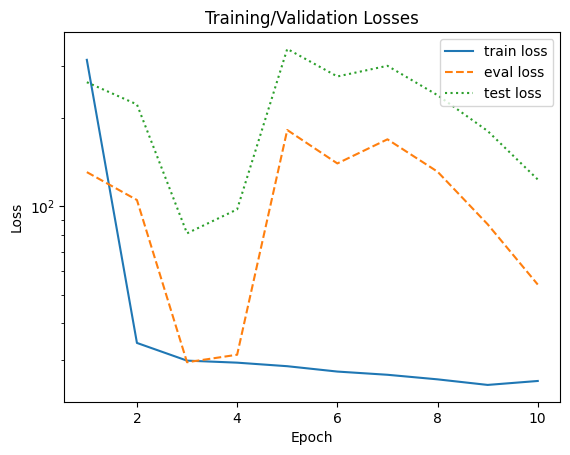

In [ ]:
trainer.plot_losses()

## Evaluation on the test set

In [ ]:
df_test = trainer.eval_rul_prediction(LOADERS[-1])

Evaluating test RUL...
Model CNN saved in models/best_model_0621130048.pt loaded to cpu


100%|██████████| 613/613 [00:09<00:00, 62.43it/s]


<Axes: >

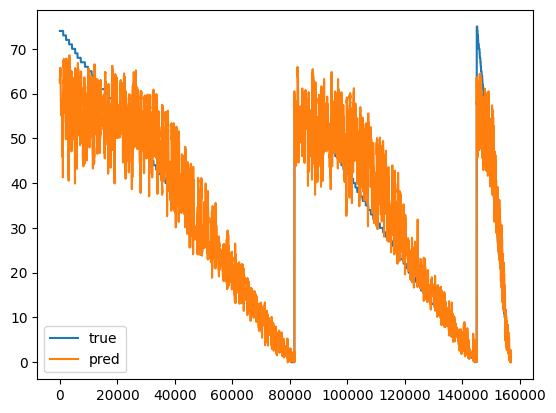

In [ ]:
df_test.plot(y=['true', 'pred'])

In [ ]:
print("train units:" , TRAIN_UNITS)
for unit in TRAIN_UNITS:
  max_cycle = df[df["unit"]==unit]["cycle"].max()
  print(f"unit: {unit}, max cycle: {max_cycle}")
print("test units:", TEST_UNITS)
for unit in TEST_UNITS:
  max_cycle = df[df["unit"]==unit]["cycle"].max()
  print(f"unit: {unit}, max cycle: {max_cycle}")

train units: [16, 18, 20]
unit: 16, max cycle: 63
unit: 18, max cycle: 71
unit: 20, max cycle: 66
test units: [2, 11, 14]
unit: 2, max cycle: 75
unit: 11, max cycle: 59
unit: 14, max cycle: 76


In [ ]:
print("predict RUL:", df_test['pred'][10000:10010].values)
print("true RUL:", df_test['true'][10000:10010].values)

predict RUL: [63.841824 63.864807 63.558617 64.451256 65.41963  64.51844  63.222282
 62.633053 62.754906 63.57112 ]
true RUL: [65. 65. 65. 65. 65. 65. 65. 65. 65. 65.]


## NASA Score


In [ ]:
def nasa_score(y_pred, y_true):
    """
    Nasa score (in 1E5) as introduced in https://arxiv.org/abs/2003.00732
    """
    d = y_pred - y_true
    score = np.sum(np.exp(d[d>=0]/10) - 1) + np.sum(np.exp(-d[d<0]/13) - 1)
    return score/1e5
def rmse(y_pred, y_true):
    """
    Root Mean Square Error
    """
    d = y_pred - y_true
    score = np.mean(np.abs(d)**2)
    return score

In [ ]:
nasa_score(df_test['pred'], df_test['true'])

1.16652328125

In [ ]:
rmse(df_test['pred'], df_test['true'])

45.8087

## Hyperparameter tuning

**Model parameters:** These are the parameters that are estimated by the model from the given data. For example the weights of a deep neural network.

**Model hyperparameters:** These are the parameters that cannot be estimated by the model from the given data. These parameters are used to estimate the model parameters. For example, the learning rate in deep neural networks.

*Hyperparameter tuning* (or hyperparameter optimization) is the process of determining the right combination of hyperparameters that maximizes the model performance. It works by running multiple trials in a single training process. Each trial is a complete execution of your training application with values for your chosen hyperparameters, set within the limits you specify. This process once finished will give you the set of hyperparameter values that are best suited for the model to give optimal results.

There are many python libraries for hyperparameter tuning:
1. RayTune
2. Optuna
3. Hyperopt
4. sklearn
etc.

There are several ways of hyperparameter tuning (all the above mentioned libraries apply several or all of those):

GridSearch : We create a discrete search space of hyperparameters to be tuned. This descrete search space grid is exhaustively searched for the best combination.

RandomSearch : We define distributions for each hyperparameter. Here the key difference is not all values are tested and values are selected at random. Since randomsearch does not test all hyperparameter values it does not necessarily return the best performing parameters, but it returns a good performing model in significantly shorter time